In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import geopandas as gpd
import os
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame
from datetime import datetime
from datetime import timedelta

from sklearn.model_selection import GridSearchCV
from sklearn import neural_network
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn import cluster
from sklearn.preprocessing import scale
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA

Using TensorFlow backend.


# Importing lagos_districts_geo.csv, orders_lagos_cl.geojson 

In [2]:
lagos_districts = pd.read_csv("lagos_districts_geo.csv")
orders_lagos = gpd.read_file('orders_lagos_cl.geojson')

In [3]:
lagos_districts['ward_name'] = orders_lagos.ward_name.unique()

In [4]:
lagos_districts_geo = lagos_districts.drop(['node_density_km', 'intersection_density_km', 'edge_density_km', 'street_density_km',
                          'clean_intersection_count', 'clean_intersection_density_km'], axis =1)

In [5]:
average_distance_ward = pd.DataFrame(orders_lagos.groupby('ward_name')['distance_km', 'QTY'].mean())
average_distance_ward.reset_index(inplace=True)
average_distance_ward = average_distance_ward.rename(columns = {"QTY": "avg_QTY_district"})
total_qty_ward = pd.DataFrame(orders_lagos.groupby('ward_name')['QTY'].sum()) #note SUM not average, because I care about total demand
total_qty_ward.reset_index(inplace=True)
total_qty_ward = total_qty_ward.rename(columns = {"QTY": "sum_QTY_district"})

In [6]:
lagos_districts_geo = lagos_districts_geo.merge(average_distance_ward, on = 'ward_name')
lagos_districts_geo = lagos_districts_geo.merge(total_qty_ward, on = 'ward_name')

In [7]:
from sklearn import cluster

def cluster_regions(gdf, n_clusters):
    
    gdf.reset_index(drop=True, inplace=True)
    
    km = cluster.KMeans(n_clusters=n_clusters)
    kmcls = km.fit(gdf.drop([lagos_districts_geo.columns[-4], lagos_districts_geo.columns[5],lagos_districts_geo.columns[6]], axis = 1).values)
    gdf = gdf.assign(cl=kmcls.labels_)
    
    return gdf

In [8]:
gdf_lagos = cluster_regions(lagos_districts_geo, 3)

In [9]:
orders_lagos_cl = orders_lagos.merge(gdf_lagos[['ward_name', 'cl']], on = 'ward_name')

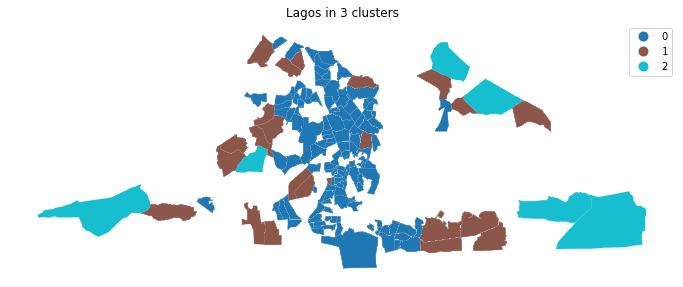

In [10]:
f, ax = plt.subplots(1, figsize=(12, 12))

orders_lagos_cl.plot(column='cl_x', categorical=True, legend=True,\
         linewidth=0.1, edgecolor='white', ax=ax)
ax.set_title('Lagos in 3 clusters')
ax.set_axis_off()

In [11]:
orders_lagos_cl = orders_lagos_cl.rename(columns = {"cl_y": "cl"})

In [12]:
min_order_date= orders_lagos_cl['Date'].min()
max_order_date= orders_lagos_cl['Date'].max()

In [13]:
blood_demand = orders_lagos_cl[['Date','QTY']].groupby('Date').sum().reset_index().copy()
blood_demand = blood_demand.merge(orders_lagos_cl[['Date','cl']], on = 'Date',how='left')
blood_demand = blood_demand.reset_index(drop=True)

In [14]:
dates = pd.date_range(blood_demand['Date'].min(), blood_demand['Date'].max()).to_list()
df_final = pd.DataFrame()
df_final['Date'] = [datetime.strftime(i, '%Y-%m-%d') for i in dates]
df_final=pd.merge(df_final, blood_demand, on='Date', how='left')
df_final=df_final.transform(lambda x: x.fillna(0))
df_final.sort_values(by=['Date'], inplace=True, ascending=True)
df_final = df_final.reset_index(drop=True)

In [15]:
df_final['weekday'] = df_final.Date.apply(lambda x: datetime.strftime(datetime.strptime(x, "%Y-%m-%d"), "%w"))
df_final['month'] = df_final.Date.apply(lambda x: datetime.strftime(datetime.strptime(x, "%Y-%m-%d"), "%m"))

# Importing the weather dataset and merging it

In [16]:
weather= pd.read_csv('WeatherDataLagos.csv')
weather=weather.rename({'weather_description':'weather'},  axis=1)

lo_visibility= ['fog', 'haze','mist','smoke','dust']
clouds = ['drizzle','few clouds','proximity squalls', 'overcast clouds']
light_rain = ['light intensity drizzle','light intensity shower rain','light rain','light thunderstorm','moderate rain']
heavy_rain =['heavy intensity rain', 'heavy intesity shower rain','shower rain','very heavy rain','squalls'] 
thunderstorm= ['thunderstorm','thunderstorm with drizzle','thunderstorm with heavy rain',
               'thunderstorm with light drizzle','thunderstorm with light rain','thunderstorm with rain']

def amend_weather_conditions(x):
    
    if x in lo_visibility:
        return 'low_visibility'
    
    elif x in clouds:
        return 'cloudy'
    
    elif x in light_rain:
        return 'light rain'
    
    elif x in heavy_rain:
        return 'heavy rain'
    
    elif x in thunderstorm:
        return 'Thunderstorm'
    
    else:
        return 'Cleal sky'

weather['new_weather_categ']= weather['weather'].apply(lambda i: amend_weather_conditions(i))

whather_conditions= sorted([x for x in weather['new_weather_categ'].unique()])

numeric_categories=[x+1 for x in range(len(whather_conditions))]

dictionary = dict(zip(whather_conditions, numeric_categories))

#defining a function that is going to be applied to the weather column in dataframe weather

def apply_numeric_codes(x):
    
    for key, value in dictionary.items():
        if key == x:
            return value
        
weather['weather_numerical']= weather['new_weather_categ'].apply(lambda i: apply_numeric_codes(i))

weather['dt']=weather['dt'].apply(lambda x: datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d'))
group_weather=weather.groupby('dt').mean().reset_index()
group_weather['weather_numerical']=group_weather['weather_numerical'].round(0)

In [17]:
#columns_to_drop=['timezone','lat','lon', 'temp_min','temp_max', 'sea_level', 'grnd_level', 'wind_deg',
                #'rain_1h', 'rain_3h','snow_1h', 'snow_1h', 'snow_3h' , 'clouds_all', 'weather_id']
    
columns_to_drop = ['timezone', 'lat', 'lon', 'sea_level', 'grnd_level', 'rain_1h', 'rain_3h', 'snow_1h',
                   'snow_3h', 'weather_id', 'temp_max', 'temp_min']

group_weather['temp_max_min_diff'] = group_weather['temp_max'] - group_weather['temp_min']


clean_weather= group_weather.drop(columns_to_drop, axis=1)

In [18]:
from sklearn import preprocessing

def preprocess_continuous(df, continuous_features):
    for col in continuous_features:
        transf = df[col].values.reshape(-1,1)
        scaler = preprocessing.StandardScaler().fit(transf)
        df[col] = scaler.transform(transf)
    
    return df

continuous_features = ['temp', 'feels_like', 'pressure', 'humidity', 'wind_speed']
clean_weather = preprocess_continuous(clean_weather, continuous_features)

In [19]:
weekday_list= [datetime.strptime(i, '%Y-%m-%d').weekday() for i in clean_weather.dt]
clean_weather['weekday'] = weekday_list

In [20]:
def amend_weekday_binary(x):
    
    if x in [0, 6]:
        return int(0)
    else:
        return int(1)

In [21]:
clean_weather['weekday']= clean_weather['weekday'].apply(lambda i: amend_weekday_binary(i))

# Importing the holidays dataset and merging it

In [22]:
public_holidays=pd.read_excel('Public_Holidays.xlsx')
public_holidays= public_holidays.dropna(how='any',axis=0)
public_holidays = public_holidays.rename(columns = {'Date_holiday': 'Date'})
dataset=pd.merge(df_final, clean_weather , left_on='Date',right_on='dt',how='left')
dataset.drop('dt', axis=1, inplace=True)
dataset['Date']=  pd.to_datetime(dataset['Date'])

final=pd.merge(dataset, public_holidays[['Date','Type']],left_on='Date',right_on='Date',how='left')

#final.drop('Date_holiday', axis=1, inplace=True)
final['Type']=final['Type'].transform(lambda x: x.fillna('A-Normal Day'))

def apply_numeric_codes(x):
    
    for key, value in dictionary.items():
        if key == x:
            return value
        
type_of_holidays= sorted([x for x in final['Type'].unique()])
numeric_holidays=[x+1 for x in range(len(type_of_holidays))]

dictionary = dict(zip(type_of_holidays, numeric_holidays))

final['holidays_type']= final['Type'].apply(lambda i: apply_numeric_codes(i))

In [23]:
final = final.drop_duplicates()

In [24]:
final['Date']=pd.to_datetime(final['Date'])

# Importing the Lagos dataset and merging it

In [25]:
stock=pd.read_csv('blood_stock_Lagos.csv')

In [26]:
stock['Date']=pd.to_datetime(stock['Date'])

In [27]:
stock_level=stock[['Date','Unfulfilled orders','Daily Blood Donations']]

In [28]:
reduced=final.merge(stock_level, on='Date', how='left')

In [29]:
reduced.to_csv('reduced.csv', index=False)

In [30]:
reduced=reduced.drop(['Type','Date'], axis=1)

# Looking at the distribution of data in order to identify the proper number classes for the target variable

unfulfilled orders median:  7.0
unfulfilled orders mean:  8.494794520547945
unfulfilled orders 75th perc:  12.0
Daily Orders median:  7.0
Daily Orders mean: 9.098630136986301
Daily Orders 75th perc: 13.0


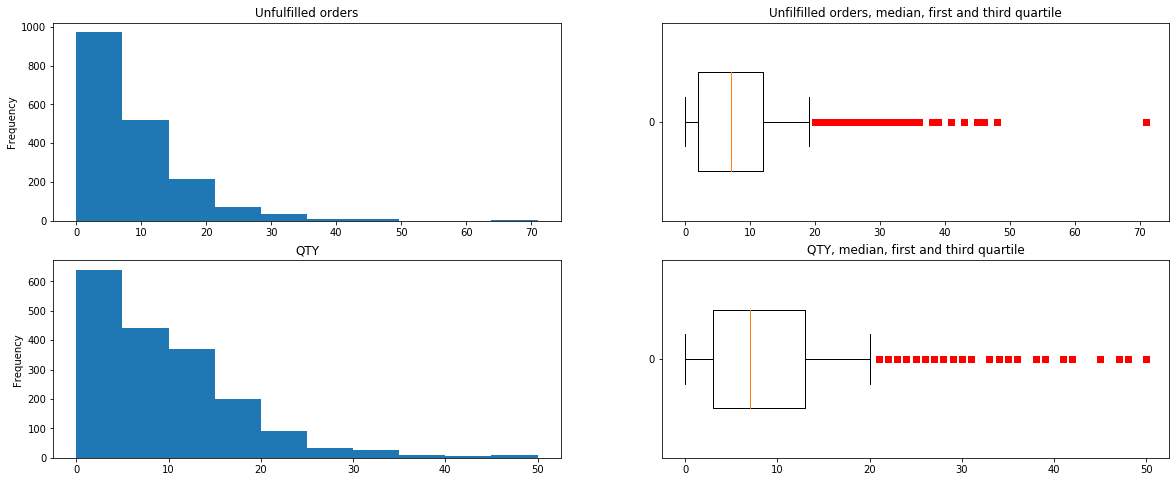

In [31]:
fig = plt.figure(figsize=(20,8))

ax1= fig.add_subplot(2,2,1)
ax2= fig.add_subplot(2,2,2)
ax3= fig.add_subplot(2,2,3)
ax4= fig.add_subplot(2,2,4)

ax1.hist(reduced['Unfulfilled orders'])
ax1.set_title('Unfulfilled orders')
ax1.set_ylabel('Frequency')
ax2.boxplot(reduced['Unfulfilled orders'], False, sym='rs', vert=False, whis=0.75, positions=[0], widths=[0.5])
ax2.set_title('Unfilfilled orders, median, first and third quartile')

ax3.hist(reduced['QTY'])
ax3.set_title('QTY')
ax3.set_ylabel('Frequency')
ax4.boxplot(reduced['QTY'], False, sym='rs', vert=False, whis=0.75, positions=[0], widths=[0.5])
ax4.set_title('QTY, median, first and third quartile')

print('unfulfilled orders median: ',reduced['Unfulfilled orders'].median())
print('unfulfilled orders mean: ',reduced['Unfulfilled orders'].mean())
print('unfulfilled orders 75th perc: ',reduced['Unfulfilled orders'].quantile(0.75))
print('Daily Orders median: ',reduced['QTY'].median())
print('Daily Orders mean:', reduced['QTY'].mean())
print('Daily Orders 75th perc:',reduced['QTY'].quantile(0.75))

This should be discussed further with the Blood Bank, however for now we assume that in a normal scenarion the 
blood bank should ideally have a blood stock not below zero in order to fulfill all the orders; given the distrubution of the onservation, we are going to assing observations between zero and 2 (25th percentile) to class 0  and ther rest to class 1 (0: capable to meet demand, 1: not capable to meet demand)

In [32]:
def transform_unfufilled_oders(x):
    
    if x >=0 and x <=2:
        return 0
    else:
        return 1

In [33]:
reduced_test = reduced.copy()

In [34]:
reduced_test['Unfulfilled orders'] = reduced_test['Unfulfilled orders'].apply(lambda i: transform_unfufilled_oders(i))

# Let's check how the obervations are distributed amongst the two classes of the target variable

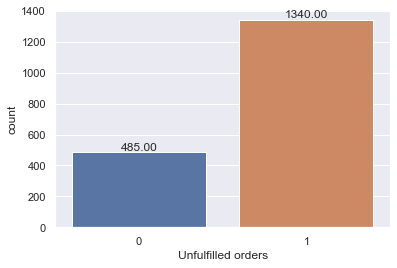

In [35]:
sns.set(style="darkgrid")
ax = sns.countplot(x="Unfulfilled orders", data=reduced_test)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', 
                va = 'center', xytext = (0, 5), textcoords = 'offset points')

Being the observations quite unbalance on the target class, we are going to use SMOTE to syntetically rebalance the
observations amongst the two classes, so that each class has the same probability of being selected by the model

In [36]:
y= reduced_test['Unfulfilled orders']
x= reduced_test.drop(['Unfulfilled orders','QTY','Daily Blood Donations'], axis=1)

os = SMOTE(random_state=0)

    # Create training and test set - test size:30% random_state=0
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=0)

columns = X_train.columns

#Apply oversampling ONLY ON training data
os_data_X,os_data_y=os.fit_sample(X_train, Y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Unfulfilled orders'])

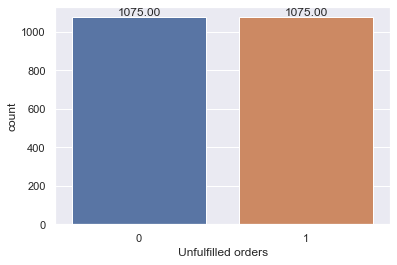

In [37]:
#dataset with classes rebalaced on the target class

sns.set(style="darkgrid")
ax = sns.countplot(x="Unfulfilled orders", data=os_data_y)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', 
                va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [38]:
params = {'max_depth': [10,30,50, 70,100, None],
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': [1, 2, 4],
          'n_estimators': [100,500,1000, 1500]}
          
gridRF = GridSearchCV(RandomForestClassifier(random_state=42), params, verbose=1, cv=3)

In [39]:
#gridRF.fit(x,y)

In [40]:
#print(gridRF.best_score_)
#print(gridRF.best_params_)

In [41]:
rf = RandomForestClassifier(max_depth = 10, max_features = 'auto', min_samples_leaf= 4, n_estimators=  500)

In [42]:
svm = SVC(kernel="rbf", C=1, probability = True)

In [43]:
from sklearn.metrics import confusion_matrix
models = [svm, rf]
names = ['svm', 'random_forest']

for i in range(len(models)):
    
    #Fit the models of training set
    fit_models=[x for x in range(0,len(models))]
    predictions_train=[x for x in range(0,len(models))]
    predictions_test=[x for x in range(0,len(models))]
    
                                        
    fit_models[i]=models[i].fit(os_data_X,os_data_y)
    predictions_train[i]=fit_models[i].predict(os_data_X)
    predictions_test[i]=fit_models[i].predict(X_test)
    cnf_matrix = confusion_matrix(Y_test, predictions_test[i])#labels=['class0','class1','class2','class3'])
    
    
    print('Classification Report for model', names[i])
    print(classification_report(Y_test, predictions_test[i]))  
    print("")
    print('accuracy_score on test set for model', names[i],'is: ',round(accuracy_score(Y_test, predictions_test[i]),3),
         ' while accuracy_score on train set is: ', round(accuracy_score(os_data_y, predictions_train[i]),3))
    print('Confusion Matrix', names[i])
    print(cnf_matrix)
    print('______________________________________________________________________________________')

/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Classification Report for model svm
              precision    recall  f1-score   support

           0       0.28      0.69      0.40       100
           1       0.74      0.33      0.45       265

    accuracy                           0.43       365
   macro avg       0.51      0.51      0.43       365
weighted avg       0.61      0.43      0.44       365


accuracy_score on test set for model svm is:  0.427  while accuracy_score on train set is:  0.563
Confusion Matrix svm
[[ 69  31]
 [178  87]]
______________________________________________________________________________________


/Users/gvaccar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Classification Report for model random_forest
              precision    recall  f1-score   support

           0       0.58      0.50      0.54       100
           1       0.82      0.86      0.84       265

    accuracy                           0.76       365
   macro avg       0.70      0.68      0.69       365
weighted avg       0.76      0.76      0.76       365


accuracy_score on test set for model random_forest is:  0.764  while accuracy_score on train set is:  0.938
Confusion Matrix random_forest
[[ 50  50]
 [ 36 229]]
______________________________________________________________________________________


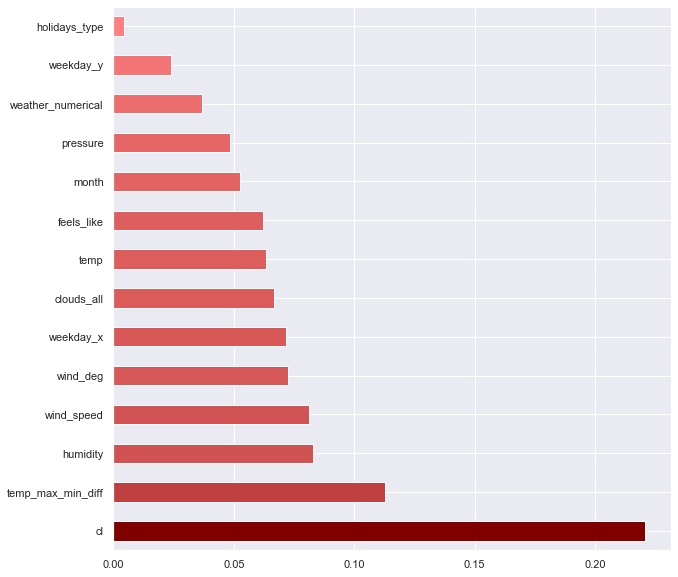

In [44]:
%matplotlib inline
import matplotlib as mp
plt.subplots(figsize=(10,10))
core_variables = pd.Series( rf.feature_importances_, index=os_data_X.columns)
core_variables = core_variables.nlargest(30)

# Colorize the graph based on likeability:
likeability_scores = np.array(core_variables)
 
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

#make the plot
core_variables.plot(kind='barh', color=color_map(data_normalizer(likeability_scores)))

In [45]:
likeability_scores

array([0.2206916 , 0.11298578, 0.08280584, 0.08122177, 0.07252314,
       0.07164371, 0.06652925, 0.06328816, 0.06213968, 0.05268998,
       0.0483103 , 0.03684542, 0.02382729, 0.00449809])

We can try and run again the same models after creating a new dimension for each of the class of the categorical 
variables

In [46]:
cols_to_convert=['cl','month','weekday_x']

In [47]:
final_with_dummies = pd.get_dummies(reduced_test,columns=cols_to_convert,drop_first=True)

In [48]:
final_with_dummies.head()

,QTY,temp,feels_like,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_numerical,temp_max_min_diff,...,month_09,month_10,month_11,month_12,weekday_x_1,weekday_x_2,weekday_x_3,weekday_x_4,weekday_x_5,weekday_x_6
0,1.0,-0.547630,-0.181659,2.544529,0.087982,-0.983643,160.291667,30.833333,2.0,1.579167,...,0,0,0,0,0,0,0,0,1,0
1,0.0,-0.596408,-0.002696,2.212325,0.320170,-1.398526,112.666667,39.375000,3.0,1.833333,...,0,0,0,0,0,0,0,0,0,1
2,0.0,-0.242847,-0.006668,2.234472,-0.333622,-1.073708,163.125000,37.291667,2.0,1.821250,...,0,0,0,0,0,0,0,0,0,0
3,0.0,-0.143117,-0.106181,2.278766,-0.266409,-0.404057,177.083333,40.416667,2.0,1.721667,...,0,0,0,0,1,0,0,0,0,0
4,0.0,-0.459085,-0.094263,2.544529,0.271288,-0.759731,157.166667,50.625000,1.0,1.400000,...,0,0,0,0,0,1,0,0,0,0


In [49]:
y= reduced_test['Unfulfilled orders']
x= reduced_test.drop(['Unfulfilled orders','QTY','Daily Blood Donations'], axis=1)

os = SMOTE(random_state=0)

    # Create training and test set - test size:30% random_state=0
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=0)

columns = X_train.columns

#Apply oversampling ONLY ON training data
os_data_X,os_data_y=os.fit_sample(X_train, Y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Unfulfilled orders'])

In [50]:
from sklearn.metrics import confusion_matrix
models = [svm, rf]
names = ['svm', 'random_forest']

for i in range(len(models)):
    
    #Fit the models of training set
    fit_models=[x for x in range(0,len(models))]
    predictions_train=[x for x in range(0,len(models))]
    predictions_test=[x for x in range(0,len(models))]
    
                                        
    fit_models[i]=models[i].fit(os_data_X,os_data_y)
    predictions_train[i]=fit_models[i].predict(os_data_X)
    predictions_test[i]=fit_models[i].predict(X_test)
    cnf_matrix = confusion_matrix(Y_test, predictions_test[i])#labels=['class0','class1','class2','class3'])
    
    
    print('Classification Report for model', names[i])
    print(classification_report(Y_test, predictions_test[i]))  
    print("")
    print('accuracy_score on test set for model', names[i],'is: ',round(accuracy_score(Y_test, predictions_test[i]),3),
         ' while accuracy_score on train set is: ', round(accuracy_score(os_data_y, predictions_train[i]),3))
    print('Confusion Matrix', names[i])
    print(cnf_matrix)
    print('______________________________________________________________________________________')

/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Classification Report for model svm
              precision    recall  f1-score   support

           0       0.28      0.69      0.40       100
           1       0.74      0.33      0.45       265

    accuracy                           0.43       365
   macro avg       0.51      0.51      0.43       365
weighted avg       0.61      0.43      0.44       365


accuracy_score on test set for model svm is:  0.427  while accuracy_score on train set is:  0.563
Confusion Matrix svm
[[ 69  31]
 [178  87]]
______________________________________________________________________________________


/Users/gvaccar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Classification Report for model random_forest
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       100
           1       0.82      0.86      0.84       265

    accuracy                           0.77       365
   macro avg       0.70      0.69      0.69       365
weighted avg       0.76      0.77      0.76       365


accuracy_score on test set for model random_forest is:  0.767  while accuracy_score on train set is:  0.935
Confusion Matrix random_forest
[[ 51  49]
 [ 36 229]]
______________________________________________________________________________________


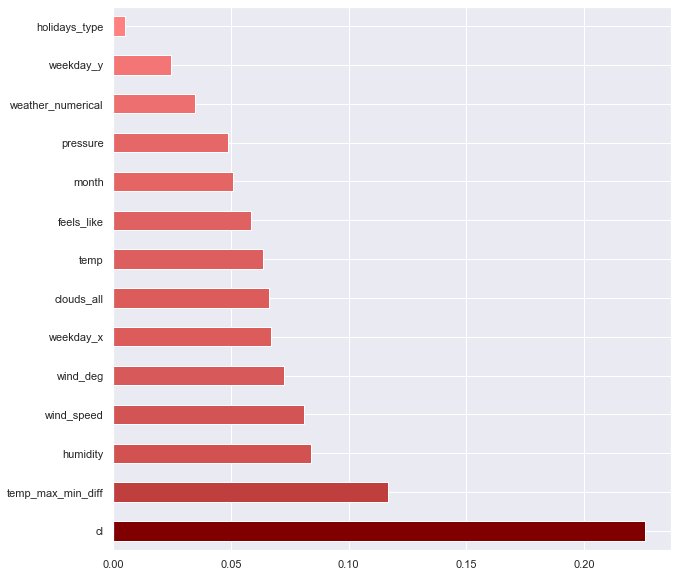

In [51]:
%matplotlib inline
import matplotlib as mp
plt.subplots(figsize=(10,10))
core_variables = pd.Series( rf.feature_importances_, index=os_data_X.columns)
core_variables = core_variables.nlargest(30)

# Colorize the graph based on likeability:
likeability_scores = np.array(core_variables)
 
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

#make the plot
core_variables.plot(kind='barh', color=color_map(data_normalizer(likeability_scores)))